# First test
Updated conda environment, updated versions of openMM and openFF, newest openFF forcefield

In [1]:
import openff.toolkit
import openmm
print("ff_name: openff_unconstrained-2.1.0.offxml")
print("ff_version: ", openff.toolkit.__version__)
print("simulation_type: tMD water solution")
print("md_engine: openMM")
print("version: ", openmm.__version__)
print("steps_time: 5.0")

ff_name: openff_unconstrained-2.1.0.offxml
ff_version:  0.14.3
simulation_type: tMD water solution
md_engine: openMM
version:  8.0
steps_time: 5.0


md_experiment_uuids:
1. fc57851e-b654-4338-bcdd-faa28ec66253
2. 7a5837f2-e4ad-4e17-a2c3-6e5e956f938b
note that there are two uuis, one for the initial batch and one to fix some errors that resulted in crashes in the simulation. But in principal, these two are the same. 

- mdfp_experiment_uuid: fc57851e-b654-4338-bcdd-faa28ec66253
- confgen_uuid: 11093a30-b6d0-4e3f-a22b-8dcad60d6a11


In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'




2023.03.3


In [9]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')

# Print the column names
column_names = [desc[0] for desc in cur.description]
print(column_names)
confids = [r[0] for r in results]
molregnos = [r[1] for r in results]
mdfps = [json.loads(r[2]['mdfp']) for r in results]
vps = [r[3] for r in results]
df_mdfps = pd.DataFrame({'confid': confids, 'molregno': molregnos, 'mdfp': mdfps, 'vp': vps})

3019 results fetched
['confid', 'molregno', 'mdfp', 'vp']


In [7]:
#some checks: how many datapoints do we have? Are we missing any?
print(len(mdfps),' MDFPs')
print(len(vps),' VPs')
cur.execute("SELECT count(*) FROM cs_mdfps_schema.experimental_data")
print(cur.fetchall(), ' experimental data points')
cur.execute("SELECT molregno FROM cs_mdfps_schema.experimental_data")
molregnos_with_vp = cur.fetchall()
molregnos_with_vp = [r[0] for r in molregnos_with_vp]
missing_molregnos = set(molregnos_with_vp) - set(molregnos)
print(len(missing_molregnos), ' missing molregnos')
#we will have to fix this...
#THESE ARE ACTUAL ERRORS IN THE SIMULATIONS FOR DIFFERENT REASONS, #TODO: FIX THIS
simulation_error_confids = [1645,1891,2048,2147,1220,1239,1382,1490,1519,2527,2851,2877,2924,3085,3155,3526,3667,3748,4107,3170]
radical_error_confids = [1816,1416]
stereo_error_confids = [1890,1439,1508,2373,2797,3341,3610,3784]
mdfp_missing_errors_should_be_fixed_confids = [2044,2168,2516,2820,3138,3159,3726,4202]
charge_errors_confids = [2058,2342]
charge_confgen_errors_confids = [1205,3075,3547,4137]
unasigned_bonderror_confids = [3736]
unasigned_angle_error_confids = [4078]
#print sum of lenght of these errors
print(len(simulation_error_confids)+len(radical_error_confids)+len(stereo_error_confids)+len(mdfp_missing_errors_should_be_fixed_confids)+len(charge_errors_confids)+len(charge_confgen_errors_confids)+len(unasigned_bonderror_confids)+len(unasigned_angle_error_confids), ' errors in the simulations')

3019  MDFPs
3019  VPs
[(3066,)]  experimental data points
47  missing molregnos
46  errors in the simulations


In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress
import numpy as np
from sklearn.model_selection import GroupKFold
def train_pred_xgboost(df,params,splits=5):
    gkf = GroupKFold(n_splits=splits)

    # Create an empty list to store the indices of each fold
    fold_indices = []

    # Group the data by 'molregno'
    groups = df['molregno']

    # Iterate over each fold
    for train_idx, test_idx in gkf.split(df, groups=groups):
        fold_indices.append((train_idx, test_idx))

    y = df['vp']  
    params = params
    output = ([],[],[],[])

    # Iterate over each fold
    for fold, (train_idx, test_idx) in enumerate(fold_indices):
        # Split the data into train and test sets for this fold
        X_train = np.array(df['mdfp'].iloc[train_idx].tolist())  # Convert lists to NumPy arrays
        X_test = np.array(df['mdfp'].iloc[test_idx].tolist())
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        molregnos_test = df['molregno'].iloc[test_idx]
        confids_test = df['confid'].iloc[test_idx]
        

        # Create DMatrix for training and testing
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False

        )
        pp = model.predict(dtest)

        output[0].append(y_test)
        output[1].append(pp)
        output[2].append(molregnos_test)
        output[3].append(confids_test)
        rmse = np.sqrt(mean_squared_error(y_test, pp, squared=False))
        print(f"Fold {fold + 1}: RMSE = {rmse}")
    return output



def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue
def density_plot(real,prediction,print_stats=True):
    if print_stats:
        slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
        print('RMSE: ', this_rmse)
        print('MAE: ', this_mae)
        print('R2: ', r2)
    fsize = 20
    fig = plt.figure(1, figsize=(10, 6.15))
    ax = plt.subplot(111)
    lower = min(prediction + real) - 2
    upper = max(prediction + real) + 2
    x = np.linspace(lower, upper,100)
    y = slope_mdfp_d*x+intercept_mdfp_d
    plt.plot(x, y, '-r')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

    import statsmodels.api as sm
    dens_u = sm.nonparametric.KDEMultivariate(data=[prediction, real],var_type='cc', bw='normal_reference')
    z = dens_u.pdf([prediction, real])

    sc = plt.scatter(prediction, real, lw=0, c=z, s=10, alpha = 0.9)

    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(labelsize=fsize)

    plt.ylabel(r'Exp. $\log (VP)$', fontsize=fsize)
    plt.xlabel(r'Predicted $\log (VP)$', fontsize=fsize)
    plt.setp(ax.get_xticklabels(), fontsize=fsize)
    plt.setp(ax.get_yticklabels(), fontsize=fsize)
    plt.grid(1,"both")
    plt.axis([lower, upper, lower, upper])
    plt.tight_layout()
    plt.show()


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.2120086081380206
Fold 2: RMSE = 1.1813995099300418
Fold 3: RMSE = 1.1496915511718304


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.2512689517410922
Fold 5: RMSE = 1.1285220740756896
RMSE:  1.409033519951439
MAE:  0.8752082787651263
R2:  0.8479784920717834


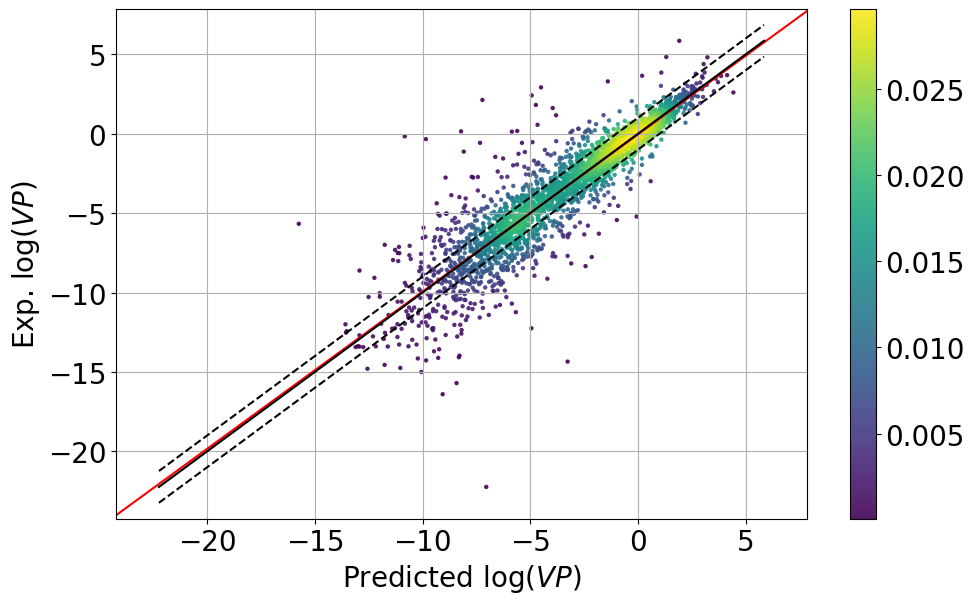

In [12]:
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(df_mdfps,params,splits=5)
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real,prediction)


## Look at some outliers

-15.743326 -22.22914798835785
187393-00-6


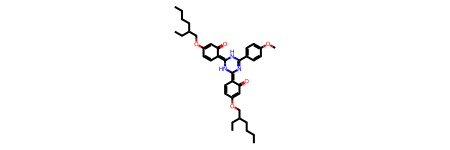

In [15]:
print(min(prediction),min(real))
#that one outlier seems strange, lets look at it
from rdkit import Chem
smiles = '[CH3]-[CH2]-[CH2]-[CH2]-[CH](-[CH2]-[CH3])-[CH2]-[O]-[C]1=[CH]-[C](=[O])/[C](=[C]2\[N]=[C](-[c]3:[cH]:[cH]:[c](-[O]-[CH3]):[cH]:[cH]:3)-[NH]/[C](=[C]3/[CH]=[CH]-[C](-[O]-[CH2]-[CH](-[CH2]-[CH3])-[CH2]-[CH2]-[CH2]-[CH3])=[CH]-[C]-3=[O])-[NH]-2)-[CH]=[CH]-1'
import cirpy
smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(smiles)))    
print(cirpy.resolve(smiles, 'cas'))
Chem.MolFromSmiles(smiles)

In [16]:
#experiemtnal value is 5.9e-20 Pa, so log(kPa)=
reach_val = 5.9e-20/1000
#another source (echmi) says  1.37E-13mmHg, lets convert this to kPa
echmi_val = 1.37e-13 * 0.133322
#Chemspired says 0.0 +- 2.6 mmHg, lets convert this to kPa
chemspire_val_lower = -2.6* 0.133322
chemspire_val_upper = 2.6* 0.133322
print(reach_val, echmi_val, chemspire_val_lower, chemspire_val_upper)
#do we remove this point?
#get the index of the outlier
index = real.index(-22.22914798835785)
print(index)
#remove the outlier
real_no_outlier = real.copy()
real_no_outlier.pop(index)
prediction_no_outlier = prediction.copy()
prediction_no_outlier.pop(index)

slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction_no_outlier, real_no_outlier)
print('RMSE: ', this_rmse)
print('MAE: ', this_mae)

5.9e-23 1.8265114e-14 -0.3466372 0.3466372
2329
RMSE:  1.3819090355316468
MAE:  0.8704681890348623


In [17]:
print(min(real_no_outlier),min(prediction_no_outlier))
smiles = '[CH3]-[CH2]-[O]-[c]1:[n]:[c](-[F]):[cH]:[c]2:[n]:[c](-[S](=[O])(=[O])-[NH]-[c]3:[c](-[Cl]):[cH]:[cH]:[cH]:[c]:3-[C](=[O])-[O]-[CH3]):[n]:[n]:1:2'
smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(smiles)))
print(cirpy.resolve(smiles, 'cas'))
Chem.MolFromSmiles(smiles)
#vap according to Unitated States Environmental Protection Agency
USEPA_val3 = 3e-16/7.5
print(USEPA_val3)

-16.397976925271976 -15.743326
147150-35-4
3.9999999999999997e-17


In [18]:
#lets also just get this out of the way: predicting the mean and look at values
mean = np.mean(vps)
mean_array = np.full(len(vps), mean)
#get r2, rmse and mae
mae = mean_absolute_error(np.array(vps), mean_array)
rmse = mean_squared_error(np.array(vps), mean_array, squared=False)
print('RMSE: ', rmse)
print('MAE: ', mae)
#good, we are not falling in that pitfall.



RMSE:  3.6127325949542177
MAE:  3.0145109987475487


In [19]:
#get real vps for datapoints with high prediction error
high_error_vps = []
for r,p in zip(real, prediction):
    if abs(r-p)>1:
        high_error_vps.append(r)
print(len(high_error_vps))
#count occurences of these in df
import pandas as pd
df = pd.read_csv('../../../../ShuZe/vp/data cleaning/cleaned_vp_all.tsv', sep='\t')
df = df[df['Temperature'] == 298.15 ]
smiles_list = []
for vp in high_error_vps:
    if len(df[df['Vapour Pressure (log10 kPa)'] == vp]) == 1:
        smiles_list.append(df[df['Vapour Pressure (log10 kPa)'] == vp]['SMILES'].values[0])
    elif len(df[df['Vapour Pressure (log10 kPa)'] == vp]['SMILES']) == 0:
        print('no smiles found')
    else:
        print('multiple smiles found')

845
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multiple smiles found
multip

656


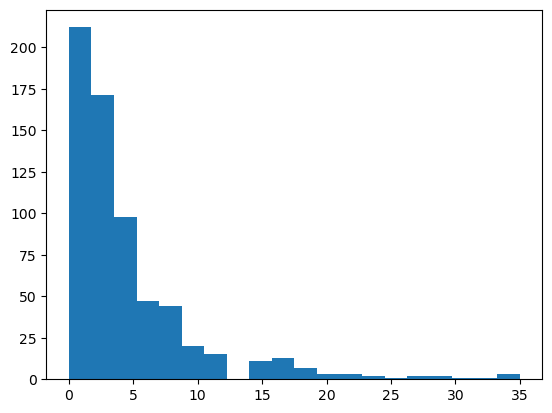

In [20]:
print(len(smiles_list))
#get number of rotatable bonds for these
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
rb = [rdMolDescriptors.CalcNumRotatableBonds(m) for m in mols]
#histogram
import matplotlib.pyplot as plt
plt.hist(rb, bins=20)
plt.show()

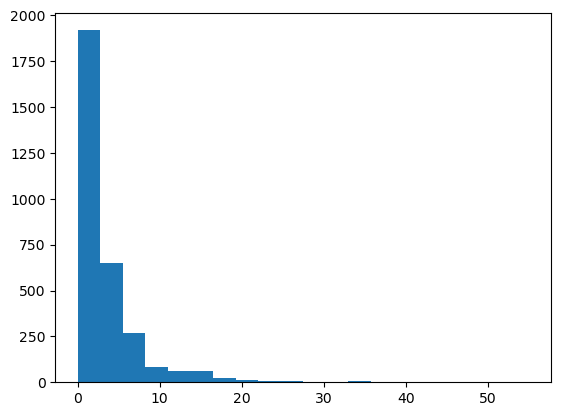

In [21]:
all_mols = [Chem.MolFromSmiles(s) for s in df['SMILES']]
all_rb = [rdMolDescriptors.CalcNumRotatableBonds(m) for m in all_mols]
plt.hist(all_rb, bins=20)
plt.show()

KstestResult(statistic=0.13892617581760067, pvalue=1.4104137824195769e-09, statistic_location=2, statistic_sign=-1)
4.391768292682927 3.1533247256294383


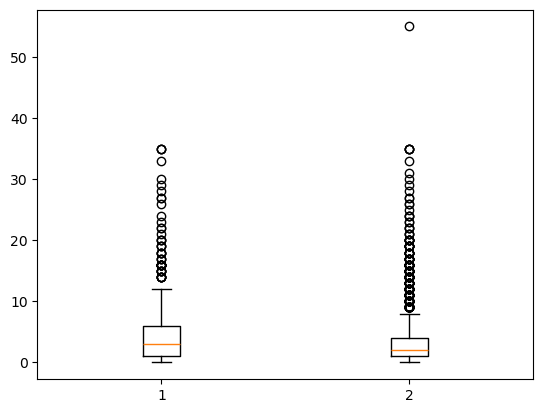

In [22]:
#check if distrubtion is different
from scipy.stats import ks_2samp
print(ks_2samp(rb, all_rb))
print(np.mean(rb), np.mean(all_rb))
#boxplots next to eachoter
import matplotlib.pyplot as plt
plt.boxplot([rb, all_rb])
plt.show()